$$
\newcommand{\B}{\text{B}}
\newcommand{\F}{\text{F}}
\newcommand{\I}{\mathbf I}
\newcommand{\intD}[1]{\int_{\Omega_e}#1\mathrm{d}\Omega}
$$

## Evaluating the B-bar method with simple examples

This is a plane strain example demonstrating the mechanical behavior of a $1\text{m}\times1\text{m}$ domain under a constant pressure of 10 MPa.

We analyze two problems, referred to as the homogeneous and heterogeneous problems. The schematics of these problems are shown in the figures below:

Homogeneous problem             |  heterogeneous problem
:-----------------------------:|:-----------------------------:
<img src="./figures/quad_M_fig_homo.png" alt="Simple test" width="200" height="200" />  | <img src="./figures/quad_M_fig.png" alt="Simple test" width="200" height="200" />

As can be seen from the schematic figures, the settings of the two problems are identical except for the boundary conditions on the bottom edge. For the homogeneous problem, the bottom boundary has a roller support with the horizontal displacement fixed at the lower left corner. Under these boundary conditions, the strain and stress remain homogeneous throughout the domain. For the heterogeneous problem, all displacement components on the bottom are fixed, leading to heterogeneous strain, and stress within the domain.

Material compressibility is accounted for by using a Poisson's ratio of 0.2 for the compressible material and 0.499 for the incompressible material.

We also consider the influence of element size on the accuracy of the solutions. Therefore, the tests are conducted using different meshes, generated by dividing the domain into a varying number of elements per edge: 2, 10, 15, 20, 25, and 30, respectively.

In [225]:
import os
import xml.etree.ElementTree as ET
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import pyvista as pv
import vtuIO
from ogs6py.ogs import OGS

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [226]:
def get_last_vtu_file_name(pvd_file_name, out_dir=out_dir):
    tree = ET.parse(Path(out_dir, pvd_file_name))
    root = tree.getroot()
    # Get the last DataSet tag
    last_dataset = root.findall(".//DataSet")[-1]

    # Get the 'file' attribute of the last DataSet tag
    file_attribute = last_dataset.attrib["file"]

    return str(Path(out_dir, file_attribute))


def get_variables_at_center(pvd_file_name):
    center = (0.5, 0.5, 0)
    file_name = get_last_vtu_file_name(pvd_file_name)
    mesh = pv.read(file_name)
    p_id = mesh.find_closest_point(center)
    u = mesh.point_data["displacement"][p_id]
    epsilon = mesh.point_data["epsilon"][p_id]
    sigma = mesh.point_data["sigma"][p_id]
    return (u, epsilon, sigma)

In [227]:
def contour_plot(pvd_file_name, title):
    file_name = get_last_vtu_file_name(pvd_file_name)
    m_plot = vtuIO.VTUIO(file_name, dim=2)
    triang = tri.Triangulation(m_plot.points[:, 0], m_plot.points[:, 1])
    stress_data = m_plot.get_point_field("sigma") * 1e-6
    u_data = m_plot.get_point_field("displacement") * 1e3

    fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
    ax[0].set_title(title, loc="left", y=1.12)
    plt.subplots_adjust(wspace=0.5)

    contour_stress = ax[0].tricontourf(triang, stress_data[:, 1], cmap="jet")
    contour_displacement = ax[1].tricontourf(triang, u_data[:, 1], cmap="jet")
    fig.colorbar(contour_stress, ax=ax[0], label="Vertical stress / [MPa]")
    fig.colorbar(contour_displacement, ax=ax[1], label="Vertical displacement / [mm]")
    fig.tight_layout()
    # plt.savefig(pvd_file_name + '.png')
    plt.show()

In [228]:
def plot_data_curve(ne, x, y_lable, file_name=""):
    # Plotting
    plt.rcParams["figure.figsize"] = [5, 5]

    plt.plot(ne, x, marker="o", linestyle="dashed")

    plt.xlabel("Number of elements per side")
    plt.ylabel(y_lable)
    # plt.legend()

    plt.tight_layout()
    if file_name != "":
        plt.savefig(file_name)
    plt.show()

In [229]:
class SingleSimulationModel:
    """An OGS run model"""

    def __init__(
        self,
        out_dir,
        output_prefix,
        order=2,
        use_bbar="false",
        is_homogeneous_mode=False,
        poisson_ratio=0.2,
    ):
        self.model = OGS(
            INPUT_FILE="simple_b_bar_test.prj", PROJECT_FILE=f"{out_dir}/modified.prj"
        )
        self.model.replace_text(use_bbar, xpath="./processes/process/use_b_bar")
        self.model.replace_text(output_prefix, xpath="./time_loop/output/prefix")
        print(f"Shape function order = {order}")
        print(f"use_b_bar = {use_bbar}")

        self.model.replace_text(
            order, xpath="./process_variables/process_variable/order"
        )
        if is_homogeneous_mode:
            xpath = "./process_variables/process_variable/boundary_conditions/boundary_condition[1]/geometry"
            self.model.replace_text("origin", xpath)

        xpath = "./parameters/parameter[name='nu']/value"
        self.model.replace_text(poisson_ratio, xpath)

        self.out_dir = out_dir
        self.output_prefix = output_prefix

    def run(self, mesh_name):
        self.model.replace_text(mesh_name, xpath="./mesh")
        self.model.write_input()

        self.model.run_model(
            logfile=Path(self.out_dir, "out.txt"), args=f"-o {self.out_dir} -m ."
        )

        return get_variables_at_center(self.output_prefix + ".pvd")

In [230]:
mesh_names = [
    "quad_edge_div_2.vtu",
    "quad_edge_div_10.vtu",
    "quad_edge_div_15.vtu",
    "quad_edge_div_20.vtu",
    "quad_edge_div_25.vtu",
    "quad_edge_div_30.vtu",
    "quad_edge_div_40.vtu",
]


def run_all_tests(ogs_mode):
    u_at_center_all = np.empty((0, 2))
    eps_at_center_all = np.empty((0, 4))
    sigma_at_center_all = np.empty((0, 4))
    for mesh_name in mesh_names:
        (u, eps, sigma) = ogs_mode.run(mesh_name)
        u_at_center_all = np.append(u_at_center_all, [u], axis=0)
        eps_at_center_all = np.append(eps_at_center_all, [eps], axis=0)
        sigma_at_center_all = np.append(sigma_at_center_all, [sigma], axis=0)

    return (u_at_center_all, eps_at_center_all, sigma_at_center_all)

In [231]:
def compare_with_analytic_solution(solutions, solution_analytic, atol_, rtol_=1e-10):
    for solution in solutions:
        np.testing.assert_allclose(
            actual=solution, desired=solution_analytic, atol=atol_, rtol=rtol_
        )

In [232]:
class AllTest:
    """Run all tests and post-process the result data"""

    def __init__(
        self,
        out_dir,
        output_prefix,
        order=2,
        is_homogeneous_mode=False,
        poisson_ratio=0.2,
    ):
        self.output_prefix_non_bbar = output_prefix + "_non_bbar"
        use_bbar = "false"
        print("Simulating without the B-bar method:")
        model_non_bbar = SingleSimulationModel(
            out_dir,
            self.output_prefix_non_bbar,
            order,
            use_bbar,
            is_homogeneous_mode,
            poisson_ratio,
        )

        (
            self.u_at_center_all_nonbbar,
            self.eps_at_center_all_nonbbar,
            self.sigma_at_center_all_nonbbar,
        ) = run_all_tests(model_non_bbar)

        print("Simulating with the B-bar method:")
        self.output_prefix_bbar = output_prefix + "_bbar"
        use_bbar = "true"
        model_bbar = SingleSimulationModel(
            out_dir,
            self.output_prefix_bbar,
            order,
            use_bbar,
            is_homogeneous_mode,
            poisson_ratio,
        )

        (
            self.u_at_center_all_bbar,
            self.eps_at_center_all_bbar,
            self.sigma_at_center_all_bbar,
        ) = run_all_tests(model_bbar)

    def contour_plot_all(self, title):
        contour_plot(self.output_prefix_non_bbar + ".pvd", title + " (non B-bar)")
        contour_plot(self.output_prefix_bbar + ".pvd", title + " (B-bar)")

    def compare_with_analytic_solution(
        self, u_analytic, eps_analytic, sigma_analytic, exlude_nonbbar=False
    ):
        compare_with_analytic_solution(self.u_at_center_all_bbar, u_analytic, 2.5e-5)
        compare_with_analytic_solution(self.eps_at_center_all_bbar, eps_analytic, 8e-16)
        compare_with_analytic_solution(
            self.sigma_at_center_all_bbar, sigma_analytic, 3e-5
        )
        if exlude_nonbbar:
            return

        compare_with_analytic_solution(self.u_at_center_all_nonbbar, u_analytic, 3e-5)

        compare_with_analytic_solution(
            self.eps_at_center_all_nonbbar, eps_analytic, 8e-16
        )

        compare_with_analytic_solution(
            self.sigma_at_center_all_nonbbar, sigma_analytic, 3e-5
        )

    def compute_errors(self):
        print(
            "Differences between the results obtained with"
            " and without the B-bar, respectively"
        )
        self.diffs_u = np.linalg.norm(
            self.u_at_center_all_nonbbar - self.u_at_center_all_bbar, axis=1
        )
        print(
            f"Displacement differences corresponding to "
            f"the mesh refinement levels: { self.diffs_u}"
        )

        self.diffs_eps = np.linalg.norm(
            self.eps_at_center_all_nonbbar - self.eps_at_center_all_bbar, axis=1
        )
        print(
            f"Strain differences corresponding to "
            f"the mesh refinement levels: {self.diffs_eps}"
        )

        self.diffs_sigma = np.linalg.norm(
            self.sigma_at_center_all_nonbbar - self.sigma_at_center_all_bbar, axis=1
        )
        print(
            f"Stress differences corresponding "
            f"to the mesh refinement levels: {self.diffs_sigma}"
        )

    def assert_errors(self, expected_u_diffs, expected_eps_diffs, expected_sigma_diffs):
        self.compute_errors()
        tolerance = 6.0e-5
        np.testing.assert_allclose(
            actual=self.diffs_u, desired=expected_u_diffs, atol=tolerance
        )

        tolerance = 5.0e-5
        np.testing.assert_allclose(
            actual=self.diffs_eps, desired=expected_eps_diffs, atol=tolerance
        )

        tolerance = 1.0e-10
        np.testing.assert_allclose(
            actual=self.diffs_sigma, desired=expected_sigma_diffs, atol=tolerance
        )

    def plot_solutions(
        self, figure_name="", scaling_u=1e3, scaling_eps=1e5, scaling_sigma=1e-6
    ):
        mesh_refine_level = np.array([2, 10, 15, 20, 25, 30, 40])
        fig, ax = plt.subplots(1, 3, figsize=(9, 3))

        def plot_subfigure(sug_figure, x, x_bbar, y_label):
            sug_figure.plot(
                mesh_refine_level, x, "C0", linestyle="dashed", label="Non B-bar"
            )
            sug_figure.plot(mesh_refine_level, x_bbar, "C2", label="B-bar")
            sug_figure.set_xlabel("Number of elements per side")
            sug_figure.set_ylabel(y_label)
            sug_figure.legend()

        plot_subfigure(
            ax[0],
            self.u_at_center_all_nonbbar[:, 1] * scaling_u,
            self.u_at_center_all_bbar[:, 1] * scaling_u,
            "Vertical displacement[mm]",
        )

        plot_subfigure(
            ax[1],
            self.eps_at_center_all_nonbbar[:, 1] * scaling_eps,
            self.eps_at_center_all_bbar[:, 1] * scaling_eps,
            r"Vertical strain[$ \times 10^{-5}$, -]",
        )

        plot_subfigure(
            ax[2],
            self.sigma_at_center_all_nonbbar[:, 1] * scaling_sigma,
            self.sigma_at_center_all_bbar[:, 1] * scaling_sigma,
            r"Vertical stress [MPa]",
        )

        plt.subplots_adjust(wspace=0.5)

        fig.tight_layout()
        if figure_name != "":
            plt.savefig(figure_name)
        plt.show()

    def plot_errors(self, figure_name=""):
        mesh_refine_level = np.array([2, 10, 15, 20, 25, 30, 40])

        fig, ax = plt.subplots(1, 3, figsize=(9, 3))

        def plot_subfigure(sub_fig, x, y_label):
            sub_fig.plot(mesh_refine_level, x, "C2")
            sub_fig.set_xlabel("Number of elements per side")
            sub_fig.set_ylabel(y_label)

        plot_subfigure(ax[0], self.diffs_u * 1e3, "Displacement difference [mm]")
        plot_subfigure(
            ax[1], self.diffs_eps * 1e5, r"Strain difference [$ \times 10^{-5}$, -]"
        )
        plot_subfigure(ax[2], self.diffs_sigma * 1e-3, r"Stress difference [kPa]")

        plt.subplots_adjust(wspace=0.5)

        fig.tight_layout()
        if figure_name != "":
            plt.savefig(figure_name)
        plt.show()

### 1. Homogeneous problem

Obviously, the analytical solutions of the stress components on tha plane are $\sigma_{11} = 0$, $\sigma_{22} = -10$ MPa. The analytical solutions of the remaining variables are

$$
\begin{align}
\sigma_{33} &= \nu(\sigma_{11}+\sigma_{22})\\
\epsilon_{11} &= \frac{\lambda}{4G(\lambda+G)}\sigma_{22}\\
\epsilon_{22} &= \epsilon_{11} + \frac{\sigma_{22}}{2G} \\
u_{1} &= \epsilon_{11}x \\
u_{2} &= \epsilon_{11}y 
\end{align}
$$
with $E$ the Young's modulus, $G=E/2(1+\nu)$ the shear modulus, $\nu$ the Poisson ratio, and $\lambda=E\nu/((1+\nu)(1-2\nu))$ the Lame constant, $u$ the displacement, $\epsilon$ the strain, and $\sigma$ the strress.

#### 1.1. Compressible material
For this case, the Poisson ratio is 0.2 as that is depicted in the schematics.

In [ ]:
output_prefix = "simple_test_homo"
all_test_homo = AllTest(out_dir, output_prefix, is_homogeneous_mode=True)

#### 1.1.1. Contour plot of the result

The stress and displacement results obtained from the test using the finest mesh are shown in the following figures.

The left figure illustrates the vertical stress within the domain expressed as an offset $s$ from -10 MPa, the analytical solution. In the simulation without the B-bar method, the offset $s$ ranges between $-0.6 \times 10^{-12}$ MPa and $0.45 \times 10^{-12}$ MPa, indicating a stress accuracy better than $10^{-11}$ MPa. With the B-bar method applied, the stress accuracy improves further to better than $10^{-12}$ MPa.


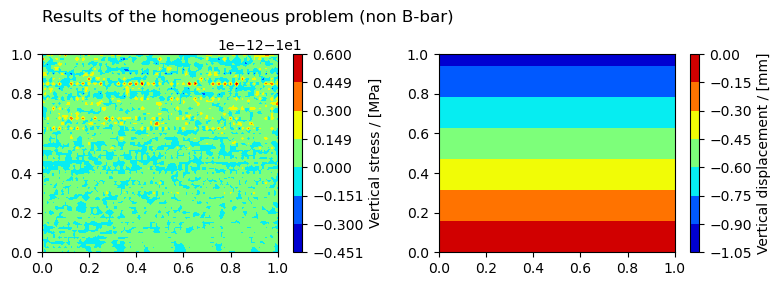

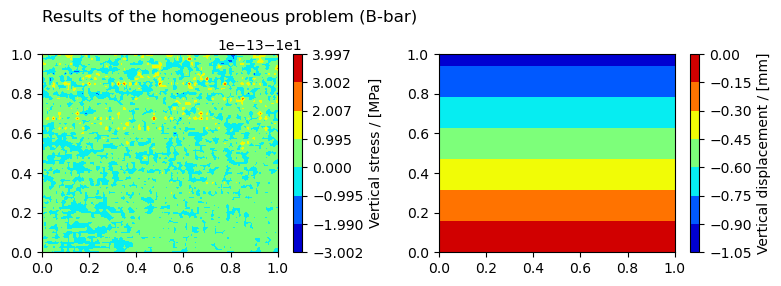

In [234]:
all_test_homo.contour_plot_all("Results of the homogeneous problem")

#### 1.1.2. Compared with the analytical solution

For this homogeneous problem, the solutions obtained using the B-bar method have almost the same accuracy as those obtained with the standard approach. This is confirmed by the following comparisons with the analytical solutions:

In [235]:
E = 1e10
nu = 0.2
lambd = nu * E / (1 + nu) / (1 - 2.0 * nu)
G = 0.5 * E / (1 + nu)
p = -10e6
eps_11 = -0.25 * lambd * p / G / (lambd + G)
eps_22 = eps_11 + 0.5 * p / G
u_1 = eps_11 * 0.5
u_2 = eps_22 * 0.5
sigma_33 = nu * p

u_analytic = np.array([u_1, u_2])
eps_analytic = np.array([eps_11, eps_22, 0.0, 0.0])
sigma_analytic = np.array([0.0, p, sigma_33, 0.0])

all_test_homo.compare_with_analytic_solution(u_analytic, eps_analytic, sigma_analytic)

#### 1.2. Incompressible material

For this case, the Poisson ratio is set to 0.499.

In [ ]:
output_prefix = "simple_test_homo_incompress"
all_test_homo_incompress = AllTest(
    out_dir, output_prefix, poisson_ratio=0.499, is_homogeneous_mode=True
)

#### 1.2.1. Contour plot of the result

The stress and displacement results obtained from the test using the finest mesh are shown in the following figures.

The same as that is explained in section 1.1.1, in the simulation without the B-bar method, the offset $s$ ranges between $-1.0 \times 10^{-10}$ MPa and $1.0 \times 10^{-10}$ MPa, indicating a stress accuracy better than $2\cdot 10^{-10}$ MPa. With the B-bar method applied, the stress accuracy improves further to better than $10^{-10}$ MPa. The simulation using the B-bar method results in a larger displacement compared to the simulation without it, which is physically correct. Specifically, the vertical displacement at the top is 8e-7 mm without the B-bar method, whereas it is 1.05e-6 mm with the B-bar method.

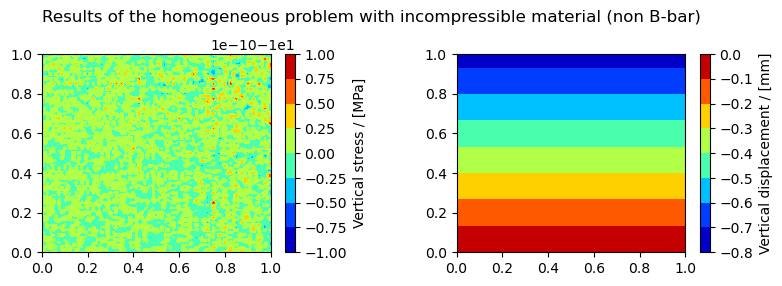

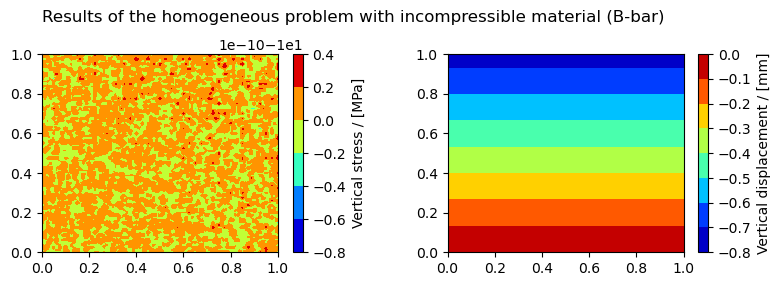

In [237]:
all_test_homo_incompress.contour_plot_all(
    "Results of the homogeneous problem with incompressible material"
)

1.2.2. Variable variation with mesh refinement level

The following three figures show the variations in vertical displacement, vertical strain, and vertical stress at the domain center as the mesh refinement level increases. These figures demonstrate that both simulations, with or without the B-bar method, deliver accurate solutions, and exhibit excellent mesh size independence. This refects the fact that this test has no volumetric locking though the material is incompressible.

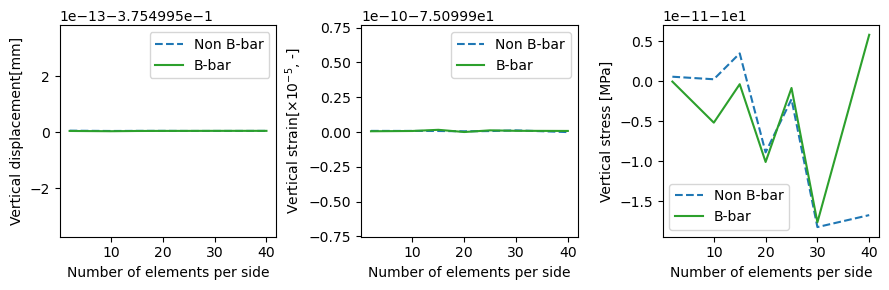

In [238]:
all_test_homo_incompress.plot_solutions()

In [239]:
E = 1e10
nu = 0.499
lambd = nu * E / (1 + nu) / (1 - 2.0 * nu)
G = 0.5 * E / (1 + nu)
p = -10e6
eps_11 = -0.25 * lambd * p / G / (lambd + G)
eps_22 = eps_11 + 0.5 * p / G
u_1 = eps_11 * 0.5
u_2 = eps_22 * 0.5
sigma_33 = nu * p

u_analytic = np.array([u_1, u_2])
eps_analytic = np.array([eps_11, eps_22, 0.0, 0.0])
sigma_analytic = np.array([0.0, p, sigma_33, 0.0])

all_test_homo_incompress.compare_with_analytic_solution(
    u_analytic, eps_analytic, sigma_analytic
)

### 2. Heterogeneous problem

#### 2.1. Compressible material

The Poisson ratio is set to 0.2 to represent the material compressiblility.

In [ ]:
output_prefix = "simple_test_hete"
all_test_hete = AllTest(out_dir, output_prefix)

#### 2.1.1. Contour plot of the result

The stress and displacement results obtained from the test using the finest mesh are shown in the following figures.

With and without the B-bar method, the variable distribution patterns look quite similar, and their magnitudes are almost identical. 


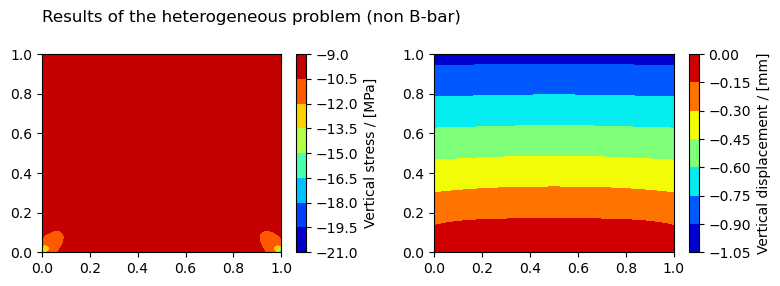

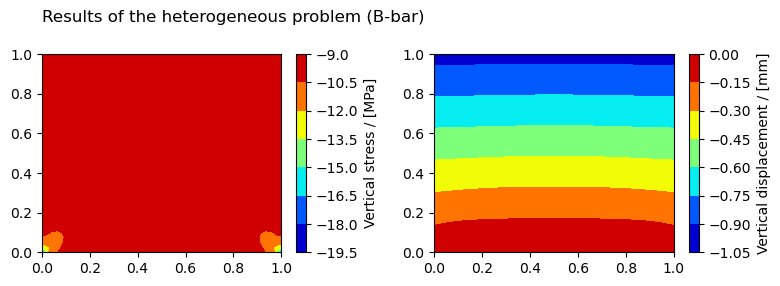

In [241]:
# run the following function to see the figures
all_test_hete.contour_plot_all("Results of the heterogeneous problem")

In [ ]:
expected_u_diffs = np.array(
    [
        1.12405235e-05,
        6.98028121e-07,
        4.86382769e-07,
        2.46115691e-07,
        2.13871759e-07,
        1.32847503e-07,
        8.56033763e-08,
    ]
)

expected_eps_diffs = np.array(
    [
        6.70627315e-05,
        1.49169891e-06,
        4.79273581e-07,
        3.38301639e-07,
        2.15516897e-07,
        1.49147744e-07,
        8.76670751e-08,
    ]
)

expected_sigma_diffs = np.array(
    [
        704485.50372313,
        17708.37333467,
        6689.6486797,
        4550.46300458,
        2812.39480024,
        2125.37608244,
        1265.2448748,
    ]
)

all_test_hete.assert_errors(expected_u_diffs, expected_eps_diffs, expected_sigma_diffs)

#### 2.1.2. Solution difference with mesh refinement level

The following three figures show the differences between the the results obtained with and without the B-bar method. Such differences tend to become tiny as the mesh refinement level increases.

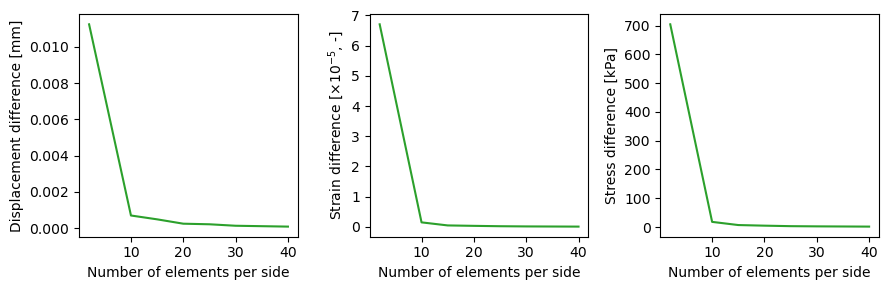

In [243]:
all_test_hete.plot_errors()

#### 2.2. Incompressible material

Considering the material's incompressibility, we changed the Poisson's ratio from 0.2 to 0.499, while keeping the Young's modulus and boundary conditions unchanged.

In [ ]:
output_prefix = "simple_test_hete_incompress"

all_test_hete_incompress = AllTest(out_dir, output_prefix, poisson_ratio=0.499)

#### 2.2.1. Contour plot of the result of incompressible material

The stress and displacement results obtained from this test using the finest mesh are shown in the following figures.

We can see that without using the B-bar method, the stress distribution exhibits strong numerical artifacts at the two lower corners of the domain, while the displacement is highly underestimated.

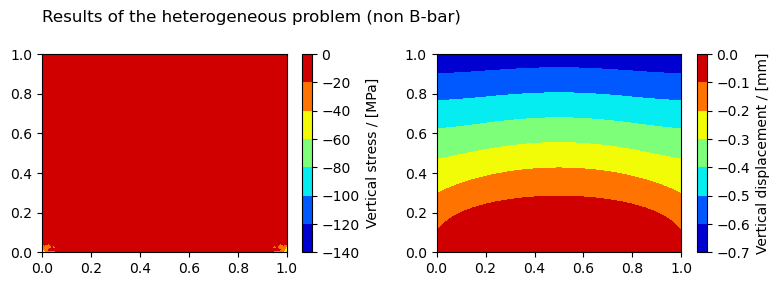

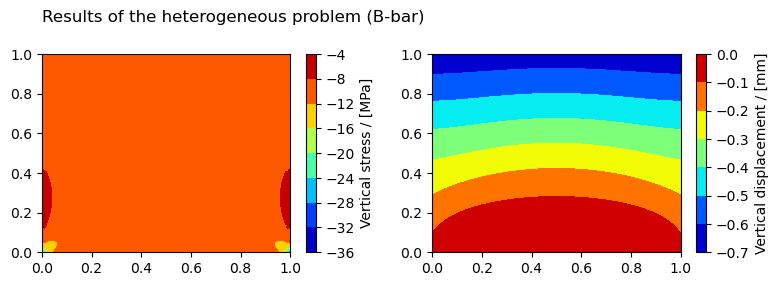

In [245]:
all_test_hete_incompress.contour_plot_all("Results of the heterogeneous problem")

#### 2.2.2. Variable variation with mesh refinement level

The following three figures show the variations in vertical displacement, vertical strain, and vertical stress at the domain center as the mesh refinement level increases. These figures demonstrate that the B-bar method provides the exact stress solution, and also delivers accurate displacement and strain results even with a relatively coarse mesh. In contrast, the standard method underestimates displacement and strain, and it fails to provide a correct stress result at almost any mesh refinement level.

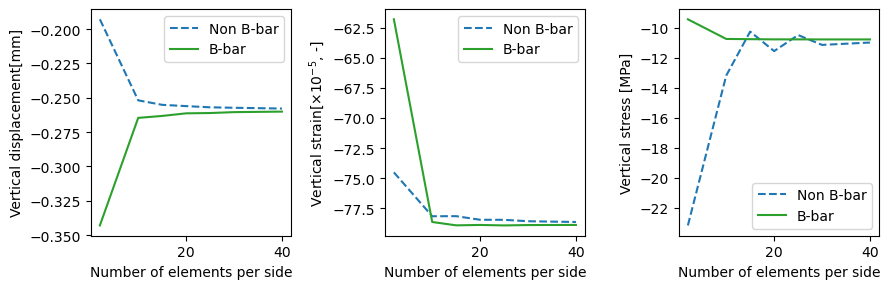

In [246]:
all_test_hete_incompress.plot_solutions()  # run this to see figures

In [ ]:
expected_u_diffs_hete = np.array(
    [
        1.50137352e-04,
        1.27562998e-05,
        8.09392747e-06,
        5.25915838e-06,
        4.17237417e-06,
        3.17767882e-06,
        2.23063182e-06,
    ]
)

expected_eps_diffs_hete = np.array(
    [
        1.74274160e-04,
        7.85738732e-06,
        1.06605607e-05,
        6.43779986e-06,
        6.47798969e-06,
        4.65601719e-06,
        3.56212669e-06,
    ]
)

expected_sigma_diffs_hete = np.array(
    [
        22405506.38102712,
        4294228.47182196,
        790313.72457601,
        1408200.09778569,
        449367.67353797,
        671266.75303949,
        388173.41044101,
    ]
)

all_test_hete_incompress.assert_errors(
    expected_u_diffs_hete, expected_eps_diffs_hete, expected_sigma_diffs_hete
)

## Conclusions
In the FEM analysis of small deformation problems,

*  The B-bar method can significantly alleviate volumetric locking in incompressible materials with a high-quality mesh.
*   When applied to problems with compressible materials, the B-bar method can still give accurate solutions with a fine mesh.
*  Only the B-bar method provides the correct solution when the material is highly incompressible and there is volumetric locking.